In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.util import ngrams
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import graphviz
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

# 0. The problem with text
Let's assume we are in the 1950s.

An image can be represented as a tensor of size 3\*M\*N. But to deal with text is not easy.

The problem with text:
 - text is **non-numeric data**
 - text is **discrete**
 - text usually has **unfixed length**
 
A common and intuitive idea is to count the number of words in a text, which becomes this bag of words model.

# 1. Quick introduction

> The **bag-of-words** model is a simplifying representation used in natural language processing and information retrieval (IR). In this model, a text (such as a sentence or a document) is represented as the **bag (multiset) of its words**, **disregarding grammar and even word order** but **keeping multiplicity**.
>
> -- <cite>Wikipedia</cite>

An quick example is,
<center> **'The cat is on the tree.'  ===> ['cat', 'is', 'on', 'the', 'the', 'tree']** </center>

In [2]:
def build_BoW(text, sorting = True):
    if (type(text) == str):
        BoW = re.findall(r'(\S+)', text.lower().rstrip('.'))
        if sorting == True:
            BoW.sort()
        return BoW
    elif (type(text) == list):
        BoW = []
        for item in text:
            BoW.append(build_BoW(item, sorting))
        return BoW
    else:
        print('wrong type')

In [3]:
sentence = 'The cat is on the tree.'
print(build_BoW(sentence))

['cat', 'is', 'on', 'the', 'the', 'tree']


Because the model **disregards grammar and word order**. You can easily construct some counter examples,
<center> **'The tree is on the cat.'  ===> ['cat', 'is', 'on', 'the', 'the', 'tree']** </center>
<center> **'Tree the on cat the is.'  ===> ['cat', 'is', 'on', 'the', 'the', 'tree']** </center>

In [4]:
sentence = 'The tree is on the cat.'
print(build_BoW(sentence))
sentence = 'Tree the on cat the is.'
print(build_BoW(sentence))

['cat', 'is', 'on', 'the', 'the', 'tree']
['cat', 'is', 'on', 'the', 'the', 'tree']


# 2. Application in NLP
Despite its disadvantage, there are many successful methods using this concept. The most direct use is in **frequence model**.
## 2.1 Frequence model
Building a frequence model is actually the same as building the **term-document matrix**

In [5]:
text = ['The cat is on the tree.',
        'Cat eats big fish.',
        'There is a tree near the river.',
        'The fish in the river is big.']

In [6]:
def build_vocabulary(corpus):
    vocabulary = set()
    BoW = build_BoW(corpus)
    for sentence in BoW:
        vocabulary.update(set(sentence))
    vocabulary = list(vocabulary)
    vocabulary.sort()
    return vocabulary

In [7]:
vocabulary = build_vocabulary(text)
print('vocabulary =',vocabulary)
print('Number of words in vocabulary:', len(vocabulary))

vocabulary = ['a', 'big', 'cat', 'eats', 'fish', 'in', 'is', 'near', 'on', 'river', 'the', 'there', 'tree']
Number of words in vocabulary: 13


In [8]:
countvectorizer = CountVectorizer(stop_words=None, token_pattern='\w+')
tdm = countvectorizer.fit_transform(text).toarray().T
df = pd.DataFrame(tdm, columns = ['sentence_1','sentence_2','sentence_3','sentence_4'])
df.insert(0,'', pd.Series(countvectorizer.get_feature_names()))
df

,,sentence_1,sentence_2,sentence_3,sentence_4
0,a,0,0,1,0
1,big,0,1,0,1
2,cat,1,1,0,0
3,eats,0,1,0,0
4,fish,0,1,0,1
5,in,0,0,0,1
6,is,1,0,1,1
7,near,0,0,1,0
8,on,1,0,0,0
9,river,0,0,1,1


## 2.2 Probabilistic (language) model

A probabilistic model is a **probability distribution of words**. If we assume that the **relative frequency** of a word can represent its probability, bag of words model becomes **unigram model**.

In [9]:
sentence = 'The cat is on the tree.'
unigram = list(set(list(ngrams(sentence.lower().rstrip('.').split(),1))))
unigram.sort()
print('Unigram model: \n',unigram)
tdm = countvectorizer.fit_transform([sentence]).toarray().T
df = pd.DataFrame(np.hstack((tdm,tdm/np.sum(tdm))), columns = ['frequency','probability'])
l = list(set(unigram))
l.sort()
df.insert(0,'', pd.Series(l))
df

Unigram model: 
 [('cat',), ('is',), ('on',), ('the',), ('tree',)]


,,frequency,probability
0,"(cat,)",1.0,0.166667
1,"(is,)",1.0,0.166667
2,"(on,)",1.0,0.166667
3,"(the,)",2.0,0.333333
4,"(tree,)",1.0,0.166667


To test our model, we want it to regenerate this sentence. Because of the bag of words model (or unigram), the probability of each word **only depends on that word's own probability** in the document, so the probability generated for a specific query of words is calculated as

$$P(w_1,w_2...w_n) = P(w_1)*P(w_1)*... *P(w_n)$$

Here, we have

$$P('The\ cat\ is\ on\ the\ tree.') = P('the')*P('cat')*P('is')*P('on')*P('the')*P('tree')$$

In [10]:
def calc_p(sentence, df, n):
    ngram = list(ngrams(sentence.lower().rstrip('.').split(), n))
    if n>2:
        for i in range(n-1,1,-1):
            ngram = ngram + list(ngrams(sentence.lower().rstrip('.').split()[:i], i))
    P = 1
    if n == 1:
        for word in ngram:
            P = P * df['probability'][df[df[''] == word].index.values[0]]      
    else:
        for word in ngram:
            P = P * df[word[-1]][df[df[''] == word[:-1]].index.values[0]] 
    return P

In [11]:
calc_p(sentence, df, 1)

8.57338820301783e-05

And based on the probability formular, the **graphical representation of unigram model** is like,

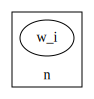

In [12]:
dot = graphviz.Digraph()
with dot.subgraph(name='cluster_0') as c:
    c.node('w_i')
    c.attr(label='n', labelloc = 'bottom')
dot

However, if we caculate the probability **conditioning on the previous word**, we get **bigram model**,

In [13]:
bigram = list(ngrams(sentence.lower().rstrip('.').split(),2))
print('Bigram model: \n', bigram)

Bigram model: 
 [('the', 'cat'), ('cat', 'is'), ('is', 'on'), ('on', 'the'), ('the', 'tree')]


In [14]:
def build_matrix(text, n, add_one = False): # n>=2
    if type(text) == list: #
        nn = n
        ngram = []
        rows = []
        vocabulary = []
        for sentence in text:
            ngram = ngram + list(ngrams(sentence.lower().rstrip('.').split(), n))
            rows = rows + list(ngrams(sentence.lower().rstrip('.').split(), n-1))
            vocabulary = vocabulary + sentence.lower().rstrip('.').split()
            if n>2:
                for i in range(n-1,1,-1):
                    ngram = ngram + list(ngrams(sentence.lower().rstrip('.').split()[:i], i))
                    rows = rows + list(ngrams(sentence.lower().rstrip('.').split()[:i-1], i-1))
    else:
        ngram = list(ngrams(text.lower().rstrip('.').split(), n)) # ngrams won't sort inside
        rows = list(ngrams(text.lower().rstrip('.').split(), n-1))
        vocabulary = list(set(text.lower().rstrip('.').split()))
        if n>2:
            for i in range(n-1,1,-1):
                ngram = ngram + list(ngrams(text.lower().rstrip('.').split()[:i], i))
                rows = rows + list(ngrams(text.lower().rstrip('.').split()[:i-1], i-1))
    
    rows = list(set(rows))
    rows.sort()
    vocabulary = list(set(vocabulary))
    vocabulary.sort()
    if add_one == True:
        matrix = np.ones((len(rows), len(vocabulary)))
    else:
        matrix = np.zeros((len(rows), len(vocabulary)))
    for tuple in ngram:
        matrix[rows.index(tuple[:-1]), vocabulary.index(tuple[-1])] += 1
    for i in range(len(rows)):
        if np.sum(matrix[i,:]) != 0:
            matrix[i,:] = matrix[i,:] / np.sum(matrix[i,:])

    df = pd.DataFrame(matrix, columns = vocabulary)
    df.insert(0, '', pd.Series(rows))
    return df

In [15]:
df = build_matrix(sentence, 2)
df

,,cat,is,on,the,tree
0,"(cat,)",0.0,1.0,0.0,0.0,0.0
1,"(is,)",0.0,0.0,1.0,0.0,0.0
2,"(on,)",0.0,0.0,0.0,1.0,0.0
3,"(the,)",0.5,0.0,0.0,0.0,0.5
4,"(tree,)",0.0,0.0,0.0,0.0,0.0


This is actually the **transition matrix** in **markov process!** And you can imagine, if the matrix is accurate, we can get a **stationary distribution**, which shows **the percentage of each word**.

You can also draw its **graphical model**,

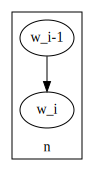

In [16]:
dot = graphviz.Digraph()
with dot.subgraph(name='cluster_0') as c:
    c.edges([('w_i-1', 'w_i')])
    c.attr(label='n', labelloc = 'bottom')
dot

Recalculate the probability to generate the original sentence **using the conditional probability**, 

\begin{split}
P('The\ cat\ is\ on\ the\ tree.') = P('the')*P('cat'|'the')*P('is'|'cat')*P('on'|'is')*P('the'|'on')*P('tree'|'the')
\end{split}

But since **we don't know what is $P('the')$**, we **initial the model with the first word 'the'** and then calcuate the probability to reconstruct the sentence. So in this case, $P('the') = 1$.

In [17]:
calc_p(sentence, df, 2)

0.25

To overcome the problem of unknowning $P(first\ word)$, we can **add start symbol(SoS or <s\>)** and **end symbol(EoS or </s\>)**. Then the joint probability is,

\begin{split}
P('The\ cat\ is\ on\ the\ tree.') =& P('<s>')*P('the'|'<s>')*P('cat'|'the')*P('is'|'cat')* \\
& P('on'|'is')*P('the'|'on')*P('tree'|'the')*P('<\s>'|'tree')
\end{split}
    
where $P('<s>') = 1$. You can regard '<s\>' to be a **signal to start the text generater**.

In [18]:
sentence = '<s> the cat is on the tree <\s>'
bigram = list(ngrams(sentence.lower().rstrip('.').split(),2))
print('Bigram model: \n',bigram)

Bigram model: 
 [('<s>', 'the'), ('the', 'cat'), ('cat', 'is'), ('is', 'on'), ('on', 'the'), ('the', 'tree'), ('tree', '<\\s>')]


In [19]:
df = build_matrix(sentence, 2)
df

,,<\s>,<s>,cat,is,on,the,tree
0,"(<\s>,)",0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"(<s>,)",0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,"(cat,)",0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,"(is,)",0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"(on,)",0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,"(the,)",0.0,0.0,0.5,0.0,0.0,0.0,0.5
6,"(tree,)",1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
calc_p(sentence, df, 2)

0.25

Although there is no improve on the probability of reconstructing the sentence, the model now can **generate sentence by itself (just feed it with '<s\>')**!

Now we want further improve the model. For this time, we caculate the probability conditioning on 2 previous words, we get **trigram model**. The probability becomes,

\begin{split}
P('The\ cat\ is\ on\ the\ tree.') =& P('<s>')*P('the'|'<s>')* P('cat'|'<s>','the') * P('is'|'the','cat') \\
    &* P('on'|'cat','is') * P('tree'|'on','the') * P('<\s>'|'the','tree') 
\end{split}

In [21]:
trigram =  [('<s>', 'the')] + list(ngrams(sentence.lower().rstrip('.').split(), 3)) 
print('Trigram model: \n', trigram)

Trigram model: 
 [('<s>', 'the'), ('<s>', 'the', 'cat'), ('the', 'cat', 'is'), ('cat', 'is', 'on'), ('is', 'on', 'the'), ('on', 'the', 'tree'), ('the', 'tree', '<\\s>')]


In [22]:
df = build_matrix(sentence, 3)
df

,,<\s>,<s>,cat,is,on,the,tree
0,"(<s>,)",0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,"(<s>, the)",0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,"(cat, is)",0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"(is, on)",0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,"(on, the)",0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,"(the, cat)",0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,"(the, tree)",1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,"(tree, <\s>)",0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
calc_p(sentence, df, 3)

1.0

Using this trigram model, we **get 100% probability**! And you can see the power of n-gram model, the more words it considered, the better accuracy.

| |Unigram |Bigram |Trigram|
|---|---|---|---|
|Probability| 8.573388e-05| 0.25| 1|

### Practical issues

However, there are still some **practical issues**. 
 - It is possible to have **new words in test set**.
 - The matrix is so sparse. **Most probabilities are 0s**. Well, that is terrible in statistics. This indicates the training set is incomplete(incapable to represent the true distribution)
 - We cannot say it is perfect because it is only trained by one sentence. It gets 100% training accuracy but will have **0% accuracy on any other sentences(test set)**. **An fair evaluation method is needed.**

**To solve the issue about new words**, one way is to **add another symbol** <UNK\> **to replace all the unknown words**. For example,
1. Choose a fixed vocabulary before training.
2. Convert any word in the training set that is not in the vocabulary to the unknown word token <UNK\>.
3. Estimate the probabilities for <UNK\> from its counts just like any other regular word in the training set.

**To solve the issue about zero probability**, we need to take some probabilty from frequent words and give it to those rare words. This modification is called **smoothing or discounting**.
1. add-1 smoothing
2. add-k smoothing
3. stupid backoff

#### Add-1 smoothing
Add-1 smoothing, also called Laplace smoothing, is the simplest way. **Add one to all the counts before we normalize them into probabilities**. Then there will be no 0 any more.
$$P_{Laplace}(w_i) = \frac{c_i+1}{n+v}$$
where n in the total number of words and v is the total number of vocabulary. Count $c_i$ is the number of word $w_i$.

In [24]:
text = ['<s> the cat is on the tree <\s>']
# text = ['<s> the cat is on the tree <\s>',
#         '<s> cat eats big fish <\s>',
#         '<s> there is a tree near the river <\s>',
#         '<s> the fish in the river is big <\s>']

text = text + text + text + text + text
df = build_matrix(text, 3, add_one = True)
df

,,<\s>,<s>,cat,is,on,the,tree
0,"(<s>,)",0.083333,0.083333,0.083333,0.083333,0.083333,0.500000,0.083333
1,"(<s>, the)",0.083333,0.083333,0.500000,0.083333,0.083333,0.083333,0.083333
2,"(cat, is)",0.083333,0.083333,0.083333,0.083333,0.500000,0.083333,0.083333
3,"(is, on)",0.083333,0.083333,0.083333,0.083333,0.083333,0.500000,0.083333
4,"(on, the)",0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.500000
5,"(the, cat)",0.083333,0.083333,0.083333,0.500000,0.083333,0.083333,0.083333
6,"(the, tree)",0.500000,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333
7,"(tree, <\s>)",0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857


#### Add-k smoothing
Very similar to add-1 smoothing. Instead of add one to all the counts, add-k smoothing adds a **small value k**.
$$P_{Laplace}(w_i) = \frac{c_i+k}{n+k*v}$$
where k is usually **smaller than 1**. It can be 0.5, 0.05 or 0.01.

#### Stupid backoff
We believe trigram is always better than bigram. **But in practice, training corpus is never exhaustive.** Sometimes we **have no examples of a particular trigram**, we can **instead estimate its probability by using the bigram
probability** $P(w_n|w_{n−1})$, or even unigram probability $P(w_n)$.

Further more, it is possible to **combine all possible grams** together to get a **weighted** equation,
\begin{split}
P(w_n|w_{n−2},w_{n−1}) =& \lambda_1*P(w_n|w_{n−2},w_{n−1}) + \lambda_2*P(w_n|w_{n−1}) + \lambda_3*P(w_n)
\end{split}
such that $\sum(\lambda_i) = 1$

**The last issue - how to fairly evaluate a language model?**

## 2.3 Perplexity 
Perplexity is a measurement of **how well a probability distribution or probability model predicts a sample**. A **low perplexity** indicates the probability distribution is **good at predicting** the sample.

\begin{split}
PP(w_1,w_2,...,w_n) &= P(w_1,w_2,...,w_n)^{-\frac{1}{n}} \\
& = \sqrt[n]{\frac{1}{P(w_1,w_2,...,w_n)}}
\end{split}

For bigram,
$$PP(w_1,w_2,...,w_n) = \sqrt[n]{\prod{\frac{1}{P(w_i|w_{i-1})}}}$$

In [25]:
def perplexity(text, df, n):
    if type(text) == list:
        P = 1
        size = 0
        for sentence in text:
            P = P*calc_p(sentence, df, n)
            size = size + len(sentence)
    else:
        P = calc_p(text, df, n)
        size = len(text)
    return P**(-1/size)

In [26]:
text = ['<s> the cat is on the tree <\s>']
# text = ['<s> the cat is on the tree <\s>',
#         '<s> cat eats big fish <\s>',
#         '<s> there is a tree near the river <\s>',
#         '<s> the fish in the river is big <\s>']
text = text + text + text + text + text

df = build_matrix(text, 3, add_one = True)
vocabulary = build_vocabulary(text)
print(len(vocabulary),'words in total:',vocabulary)

7 words in total: ['<\\s>', '<s>', 'cat', 'is', 'on', 'the', 'tree']


In [27]:
text = ['<s> the cat is on the tree <\s>']
# text = ['<s> the cat is on the tree <\s>',
#         '<s> cat eats big fish <\s>',
#         '<s> there is a tree near the river <\s>',
#         '<s> the fish in the river is big <\s>']
perplexity(text, df, 3)

1.169430765597687

Perplexity is good because we test with training sentence. There are more grams we are missing. For **our trigram model**, we have 7 words in vocabulary. So there are **1+5+5*5 = 31 valid grams**(including 1 unigram and 30 bigram) to be the rows of probability matrix, but we **only have 8-1 = 7!** Suppose **a new test sentence has 7 words** and **all its grams are new**, the probability of each word is thus $\frac{1}{7}$. So the perplexity is **7**. If there are **2 test sentences** like this, the **perplexity becomes 49!**

Example from WSJ corpus, trained on **38M tokens**, tested on **1.5 M tokens**, **vocabulary: 20K**

| |Unigram |Bigram |Trigram|
|---|---|---|---|
|Perplexity| 962| 170| 109|

Same conclusion: Using higher degree n-gram, perplexity is decreasing. And model is better.

# 3. Applications in other fields
## Bag of visual words
Besides application in NLP, bag of words model is also applied in computer vision. Before 2012, bag of visual words model is the state of art in image classification.

Steps:
1. Suppose we have M **labeled** images. We **extract feature using SIFT(Scale-Invariant Feature Transform)** from these images and finally **get N SIFT features in total**. (Each image may have different number of features. Every feature is a vector of 128 dimensions)
2. Using **k-means**(or random forest) to **cluster these N features into K classes**, which are **the visual words**. Therefore, each image is **a visual sentence**, which can be represented as **a vector of K dimensions**. Each element shows the number of those visual words. 
3. Using **multiclass classifier** to classify test images

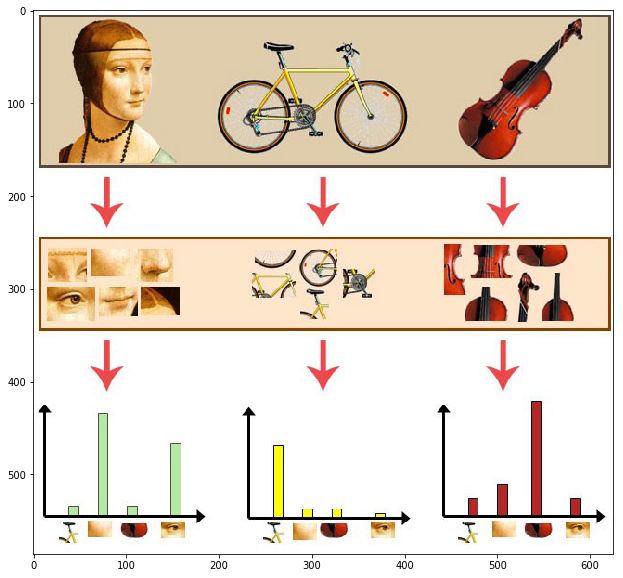

In [28]:
img=mpimg.imread('./img/bovg.jpeg')
plt.figure(figsize=(15,10))
plt.imshow(img)

#### An example of SIFT feature (not bag of visual words model)

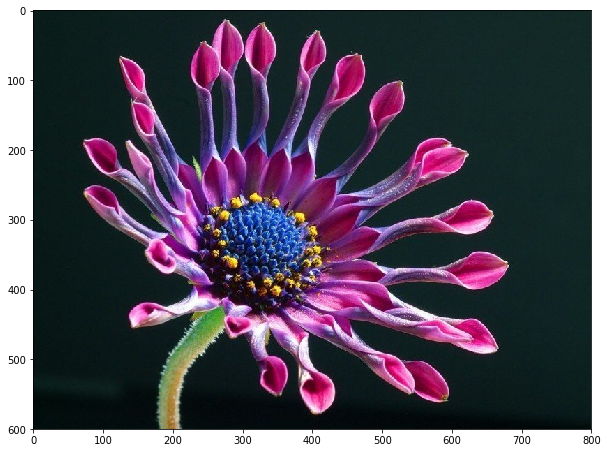

In [29]:
img = cv2.imread('./img/flower.jpg')
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img,cv2.CV_32S))

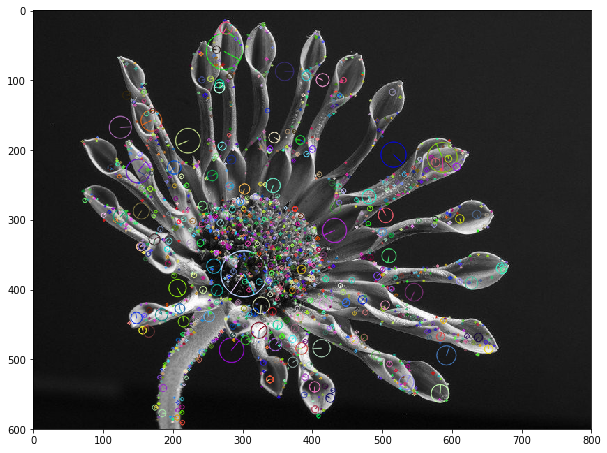

In [30]:
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray,None)
img=cv2.drawKeypoints(gray,kp,outImage=None)
img=cv2.drawKeypoints(gray,kp,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS, outImage=None)
plt.figure(figsize=(10,10))
plt.imshow(img)

### Bioinformatics

Like text, DNA and protein are **sequential data**. Bag of words model or n-gram still works.

|Field|Unit|Sample sequence|unigram|bigram|trigram|
|---|---|---|---|---|---|
|Protein sequencing|amino acid|… Cys-Gly-Leu-Ser-Trp …|…, Cys, Gly, Leu, Ser, Trp, …|…, Cys-Gly, Gly-Leu, Leu-Ser, Ser-Trp, …|…, Cys-Gly-Leu, Gly-Leu-Ser, Leu-Ser-Trp, …|
|DNA sequencing|base pair|…AGCTTCGA…|…, A, G, C, T, T, C, G, A, …|…, AG, GC, CT, TT, TC, CG, GA, …|…, AGC, GCT, CTT, TTC, TCG, CGA, …|

# Reference
1. Daniel Jurafsky, Speech and Language Processing
2. Illinois CS447: Natural Language Processing
3. Joshua Goodman, A Bit of Progress in Language Modeling
4. https://kushalvyas.github.io/BOV.html
5. Wikipedia